In [1]:
from pathlib import Path
from dataset import read_bx_csv

data_root = Path('data/BX-CSV-Dump')
users = read_bx_csv(data_root / 'BX-Users.csv')
books = read_bx_csv(data_root / 'BX-Books.csv')
ratings = read_bx_csv(data_root / 'BX-Book-Ratings.csv')

2023-09-01 17:33:06.174471: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Predict rating of a book for a user

6500 books (after filtr.), 11000 users, 320K ratings, of which 111K explicit

nebo < 2OO ratings per user filter
- 224K total ratings, of which 91K explicit ratings
    - otazka jak vypada histogram explicit ratings per book/user

ratings - málo, protože implicit musim ignorovat
- mozna by šlo self training na implicit ratings?
    - dost prace, takze ted ne

pouzit ostatni featury?
- nektery jsou n/a
- vsechny v podstate categorical
    - i year a age je podle mě lepší bucketovat než standard scaler...


In [2]:
# create wide form of ratings
ratings_wide = ratings.merge(books, on='ISBN').merge(users, on='User-ID').drop(columns=[f'Image-URL-{size}' for size in 'SML'])
ratings_wide.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"tyler, texas, usa",NaN
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"cincinnati, ohio, usa",23.0
2,2313,0812533550,9,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986,Tor Books,"cincinnati, ohio, usa",23.0
3,2313,0679745580,8,In Cold Blood (Vintage International),TRUMAN CAPOTE,1994,Vintage,"cincinnati, ohio, usa",23.0
4,2313,0060173289,9,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells,1996,HarperCollins,"cincinnati, ohio, usa",23.0


In [3]:
from dataset import filter_ratings
f_ratings_wide = filter_ratings(ratings_wide, user_ratings_max_count=200)

In [4]:
# clip user age to 100
f_ratings_wide['Age'] = f_ratings_wide['Age'].clip(upper=100)

<Axes: >

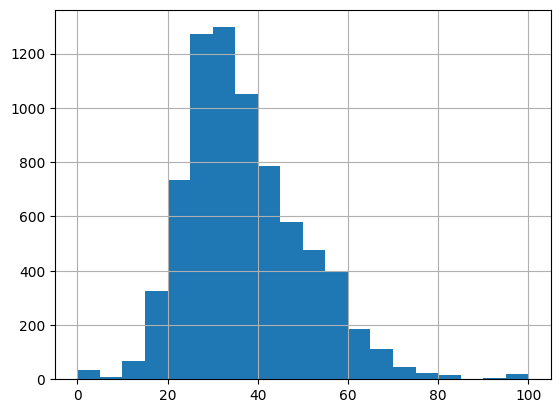

In [5]:
# aggregate users from filtered ratings
f_users = f_ratings_wide.groupby('User-ID').first().reset_index()
f_users.Age.hist(bins=20)

In [6]:
# replace n/a in user age with -100 (for bucketing to onehot - unknown age will get its own category)
f_ratings_wide['Age'] = f_ratings_wide['Age'].fillna(-100)

<Axes: >

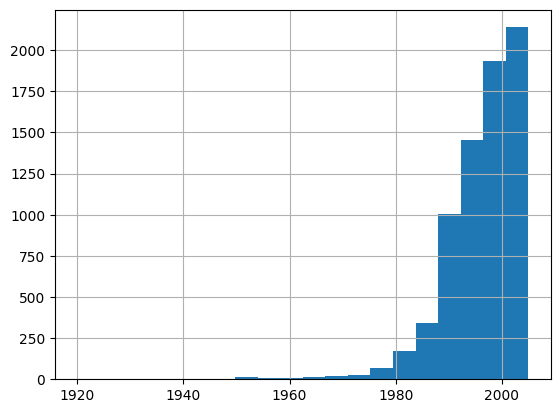

In [7]:
# aggregate books from filtered ratings
f_books = f_ratings_wide.groupby('ISBN').first().reset_index()
f_books[f_books['Year-Of-Publication'] > 0]['Year-Of-Publication'].hist(bins=20)

In [8]:
f_ratings_wide.isna().sum()

User-ID                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Location               0
Age                    0
book_ratings_count     0
user_ratings_count     0
dtype: int64

In [9]:
import numpy as np

In [10]:
%load_ext autoreload
%autoreload complete --print

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from statistics import LinearRegression
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pandas as pd

from hash_transform import HashingTransformer

In [11]:

# Location could really be important, esp. if people cannot read in all languages in the dataset
categoricals = ['Book-Author', 'Publisher'] #'Location']


# Neural network in tensorflow


In [12]:
f_ratings_wide.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Location,Age,book_ratings_count,user_ratings_count
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"cincinnati, ohio, usa",23.0,60,15
2,2313,0812533550,9,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986,Tor Books,"cincinnati, ohio, usa",23.0,23,15
3,2313,0679745580,8,In Cold Blood (Vintage International),TRUMAN CAPOTE,1994,Vintage,"cincinnati, ohio, usa",23.0,55,15
4,2313,0060173289,9,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells,1996,HarperCollins,"cincinnati, ohio, usa",23.0,130,15
5,2313,0385482388,5,The Mistress of Spices,Chitra Banerjee Divakaruni,1998,Anchor Books/Doubleday,"cincinnati, ohio, usa",23.0,80,15


In [13]:
# Count
f_ratings_wide.nunique()



User-ID                10734
ISBN                    7268
Book-Rating               11
Book-Title              6484
Book-Author             2314
Year-Of-Publication       55
Publisher                527
Location                4840
Age                       88
book_ratings_count       312
user_ratings_count       191
dtype: int64

In [14]:
# split Location column ex: cincinnati, ohio, usa

f_ratings_wide[['City', 'State', 'Country']] = f_ratings_wide['Location'].str.rsplit(",", n=2, expand=True).apply(lambda series: series.str.strip())

In [15]:
f_ratings_wide[['City', 'State', 'Country']].nunique()

City       3814
State       406
Country      75
dtype: int64

In [41]:
import tensorflow as tf

from dataset import train_test_split, squash_user_ids
from ranking_nn import scale_dataset, BXRankingModel, RankingModel

dataset = f_ratings_wide.drop(columns=['Book-Title', 'Location'])
new_to_orig_user_id, orig_to_new_user_id = squash_user_ids(dataset)

train, test = train_test_split(scale_dataset(dataset))

rating_model = RankingModel(f_ratings_wide, l2_regularization=0.1, embedding_dimensions={
    'User-ID': 32,
    # 'Book-Title': 32,
    'ISBN': 32,
    'Book-Author': 10,
    'Publisher': 5,
    'City': 10,
    'State': 7,
    'Country': 5,

})

model = BXRankingModel(rating_model)

tf.random.set_seed(42)

batch_size = 4096
epochs = 20

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.CosineDecay(0.01, epochs*len(train) //batch_size)),

)

print('Test loss before training:', np.mean([model.compute_loss(batch) for batch in test.batch(batch_size)]))

model.fit(
    train.shuffle(len(train)).batch(batch_size),
    validation_data=test.batch(batch_size),  # todo change to val dataset
    epochs=epochs,
)


2023-09-03 16:16:24.318571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype string and shape [224170]
	 [[{{node Placeholder/_7}}]]
2023-09-03 16:16:24.319797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [224170]
	 [[{{node Placeholder/_1}}]]


Test loss before training: 21.495049
Epoch 1/20


2023-09-03 16:16:28.457150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype string and shape [224170]
	 [[{{node Placeholder/_7}}]]
2023-09-03 16:16:28.458428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype double and shape [224170]
	 [[{{node Placeholder/_9}}]]


44/44 [==============================] - ETA: 0s - root_mean_squared_error: 3.7636 - loss: 14.1593 - regularization_loss: 4.9039 - total_loss: 19.0632

2023-09-03 16:16:38.995694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype string and shape [224170]
	 [[{{node Placeholder/_6}}]]
2023-09-03 16:16:38.996752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype double and shape [224170]
	 [[{{node Placeholder/_11}}]]


44/44 [==============================] - 15s 194ms/step - root_mean_squared_error: 3.7636 - loss: 14.1358 - regularization_loss: 4.8154 - total_loss: 18.9512 - val_root_mean_squared_error: 3.5953 - val_loss: 12.7245 - val_regularization_loss: 0.8642 - val_total_loss: 13.5887
Epoch 2/20
44/44 [==============================] - 12s 190ms/step - root_mean_squared_error: 3.4450 - loss: 11.8813 - regularization_loss: 0.5126 - total_loss: 12.3940 - val_root_mean_squared_error: 3.6088 - val_loss: 12.7943 - val_regularization_loss: 0.2888 - val_total_loss: 13.0831
Epoch 3/20
44/44 [==============================] - 12s 179ms/step - root_mean_squared_error: 3.3849 - loss: 11.4688 - regularization_loss: 0.2568 - total_loss: 11.7256 - val_root_mean_squared_error: 3.5766 - val_loss: 12.6205 - val_regularization_loss: 0.2024 - val_total_loss: 12.8229
Epoch 4/20
44/44 [==============================] - 11s 172ms/step - root_mean_squared_error: 3.3646 - loss: 11.3305 - regularization_loss: 0.2126 - t

In [44]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf


from dataset import train_test_split, squash_user_ids
from ranking_nn import scale_dataset, BXRankingModel, RankingModel

dataset = f_ratings_wide.drop(columns=['Book-Title', 'Location'])
new_to_orig_user_id, orig_to_new_user_id = squash_user_ids(dataset)

train, test = train_test_split(scale_dataset(dataset))

DROPOUT = 0.5
L2 = 0.01

rating_model = RankingModel(f_ratings_wide, l2_regularization=L2, dropout=DROPOUT, embedding_dimensions={
    'User-ID': 32,
    # 'Book-Title': 32,
    'ISBN': 32,
    'Book-Author': 10,
    'Publisher': 5,
    'City': 10,
    'State': 7,
    'Country': 5,

})

model = BXRankingModel(rating_model)

tf.random.set_seed(42)

batch_size = 4096
epochs = 20

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=tf.keras.optimizers.schedules.CosineDecay(0.01, epochs*len(train) //batch_size)),
)

print('Test loss before training:', np.mean([model.compute_loss(batch) for batch in test.batch(batch_size)]))

model.fit(
    train.shuffle(len(train)).batch(batch_size),
    validation_data=test.batch(batch_size),  # todo change to val dataset
    epochs=epochs,
)


2023-09-04 22:28:59.471840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [224170]
	 [[{{node Placeholder/_4}}]]
2023-09-04 22:28:59.474077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [224170]
	 [[{{node Placeholder/_1}}]]


Test loss before training: 21.34957
Epoch 1/20


2023-09-04 22:29:04.062854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [224170]
	 [[{{node Placeholder/_1}}]]
2023-09-04 22:29:04.063695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int64 and shape [224170]
	 [[{{node Placeholder/_8}}]]


44/44 [==============================] - ETA: 0s - root_mean_squared_error: 3.7560 - loss: 14.1021 - regularization_loss: 1.0495 - total_loss: 15.1517

2023-09-04 22:29:14.269896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [224170]
	 [[{{node Placeholder/_2}}]]
2023-09-04 22:29:14.271872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype string and shape [224170]
	 [[{{node Placeholder/_3}}]]


44/44 [==============================] - 14s 181ms/step - root_mean_squared_error: 3.7560 - loss: 14.0792 - regularization_loss: 1.0392 - total_loss: 15.1184 - val_root_mean_squared_error: 3.5864 - val_loss: 12.5866 - val_regularization_loss: 0.5733 - val_total_loss: 13.1598
Epoch 2/20
44/44 [==============================] - 12s 198ms/step - root_mean_squared_error: 3.4304 - loss: 11.7833 - regularization_loss: 0.4522 - total_loss: 12.2355 - val_root_mean_squared_error: 3.5939 - val_loss: 12.6730 - val_regularization_loss: 0.3582 - val_total_loss: 13.0312
Epoch 3/20
44/44 [==============================] - 12s 189ms/step - root_mean_squared_error: 3.3560 - loss: 11.2771 - regularization_loss: 0.3437 - total_loss: 11.6209 - val_root_mean_squared_error: 3.5949 - val_loss: 12.7275 - val_regularization_loss: 0.2843 - val_total_loss: 13.0119
Epoch 4/20
44/44 [==============================] - 12s 212ms/step - root_mean_squared_error: 3.2954 - loss: 10.8730 - regularization_loss: 0.3062 - t